In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2024-11-26 17:16:58.120480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# One-Step Forecast 

In [2]:
df = pd.read_csv('daily_weather.csv', parse_dates=True)

print(df.shape)

df.head()

(2923, 2)


,date,temperature
0,01/01/2009,-6.810629
1,02/01/2009,-3.360486
2,03/01/2009,5.435694
3,04/01/2009,7.283889
4,05/01/2009,12.690069


In [3]:
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y").dt.strftime("%Y-%m-%d")

df['date'] = pd.to_datetime(df['date'])

df.head()

,date,temperature
0,2009-01-01,-6.810629
1,2009-01-02,-3.360486
2,2009-01-03,5.435694
3,2009-01-04,7.283889
4,2009-01-05,12.690069


In [4]:
df = df.set_index('date')

df.index.freq = 'D'

df.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=2923, freq='D')

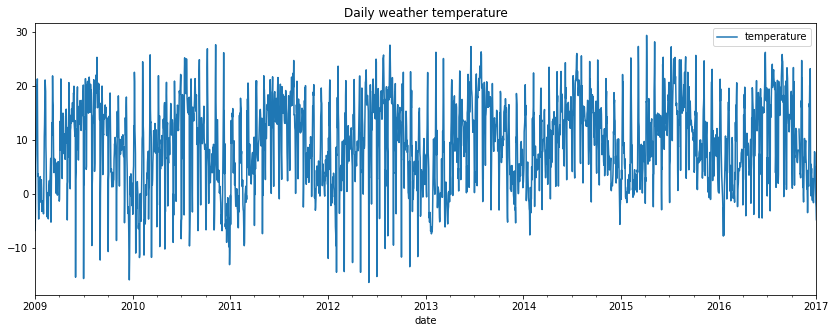

In [6]:
plt.rcParams["figure.figsize"] = [14, 5]  

df.plot(title='Daily weather temperature')
plt.show()

### Split data: train, valid, test

In [7]:
# Step 1: 
# train set: 2009-01-01 .. 2012-12-30 (4 years)
# validation set: 2013-01-01 .. 2014-12-30  (2 years)
# test set:  2015-01-01 .. 2017-01-01  (2 years)

val_ind = "2013-01-01"   
test_ind = "2015-01-01"

train = df.copy()[df.index < val_ind] 
valid = df.copy()[(df.index >= val_ind) & (df.index < test_ind)]
test = df.copy()[df.index >= test_ind]

print(train.shape, valid.shape, test.shape)

(1461, 1) (730, 1) (732, 1)


In [8]:
# Step 2: 
# Scale data to be in range (0, 1)

scaler = MinMaxScaler()
train["temperature"] = scaler.fit_transform(train)
 
valid["temperature"] = scaler.transform(valid)   # Transform validation set using parameters from training set
test["temperature"] = scaler.transform(test)     # Transform test set using parameters from training set


In [9]:
# Time series sliding window

# Function to convert a time series into a window of inputs
# Returns a DataFrame with a specified number of independent variables (columns) and y target variables (columns). 
# The total number of columns returned is based on the sliding window parameter 

def slideWindow(df, window_in, horizon):
    
    d = df.values
    X, y = [], [] 
    idx = df.index[:-window_in]
    
    for start in range(len(df)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))     
        y.append(d[end:out].ravel())        # ravel() is equivalent to reshape(-1): returns contiguous flattened array 
        
    cols_x = [f'x{i}' for i in range(1, window_in+1)]
    cols_y = [f'y{i}' for i in range(1, horizon+1)]

    df_xs = pd.DataFrame(X, index=idx, columns=cols_x)
    df_y = pd.DataFrame(y, index=idx, columns=cols_y)
    
    return pd.concat([df_xs, df_y], axis=1).dropna()

### Predicting one step ahead

window_in = 6      the number of lag variables

HORIZON = 1        next day temperature


In [10]:
# Step 3: 
# shift data to create the input samples

win_in = 6  
HORIZON = 1

train_shift = slideWindow(train, win_in, HORIZON)
valid_shift = slideWindow(valid, win_in, HORIZON)
test_shift = slideWindow(test, win_in, HORIZON)

train_shift.head()

,x1,x2,x3,x4,x5,x6,y1
date,,,,,,,
2009-01-01,0.218753,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488
2009-01-02,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982
2009-01-03,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971
2009-01-04,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903
2009-01-05,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903,0.446006


### Convert  train/valid/test  sets to tensors

In [12]:
# Step 4: convert data to tensors (three-dimensional structure)

y_train = train_shift['y1'].to_numpy()
print(y_train.shape)

X_train = train_shift.iloc[:,:-1].to_numpy()   # all columns except the last   
X_train = X_train.reshape(X_train.shape[0], win_in, 1)
print(X_train.shape)

y_valid = valid_shift['y1'].to_numpy()
print(y_valid.shape)
 
X_valid = valid_shift.iloc[:,:-1].to_numpy()   # 
X_valid = X_valid.reshape(X_valid.shape[0], win_in, 1)

print(X_valid.shape)

y_test = test_shift['y1'].to_numpy()
print(y_test.shape)
 
X_test = test_shift.iloc[:,:-1].to_numpy()    
X_test = X_test.reshape(X_test.shape[0], win_in, 1)

print(X_test.shape)

(1455,)
(1455, 6, 1)
(724,)
(724, 6, 1)
(718,)
(718, 6, 1)


## GRU model to predict the next temperature day

In [11]:
# Horizon=1,to predict next temperature day
HORIZON = 1

# The latent dimension (LATENT_DIM): is the number of units in the RNN layer.
LATENT_DIM = 5

# The batch size (BATCH_SIZE): is the number of samples per mini-batch.
BATCH_SIZE = 32

# The epochs (EPOCHS): is the maximum number of times the training algorithm will cycle through all samples
EPOCHS = 50

# Is the number of epochs after which the training stops if the validation loss has not improved by a minimum delta
PATIENCE = 5

In [12]:
np.random.seed(42)

gru_model = Sequential()
gru_model.add(GRU(LATENT_DIM, input_shape=(win_in, 1)))
gru_model.add(Dense(HORIZON))

gru_model.compile(optimizer="RMSprop", loss="mse")
gru_model.summary()

2023-12-06 12:23:09.341810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5)                 120       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [13]:
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0, patience=PATIENCE)

history = gru_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
46/46 [==============================] - 3s 17ms/step - loss: 0.1470 - val_loss: 0.0514
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0308 - val_loss: 0.0192
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0236 - val_loss: 0.0168
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0152
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0196 - val_loss: 0.0142
Epoch 6/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0124
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0175 - val_loss: 0.0119
Epoch 8/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0113
Epoch 9/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0168 - val_loss: 0.0112
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 11/50
46/46 

In [14]:
gru_ts_pred = gru_model.predict(X_test)

results = test_shift[['y1']].copy()

results['GRU_pred'] = gru_ts_pred

results[['y1', 'GRU_pred']] = scaler.inverse_transform(results[['y1', 'GRU_pred']])
print(results.shape)
results.head()


23/23 [==============================] - 0s 2ms/step
(718, 2)


,y1,GRU_pred
date,,
2015-01-01,22.116458,11.978891
2015-01-02,18.175000,17.988037
2015-01-03,20.717986,15.721015
2015-01-04,8.910139,16.759583
2015-01-05,9.433264,8.853665


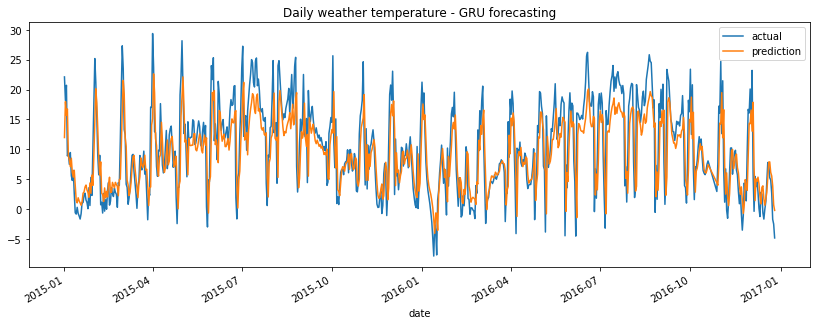

In [15]:
results.plot()
plt.title('Daily weather temperature - GRU forecasting')
plt.legend(['actual', 'prediction'])
plt.show()

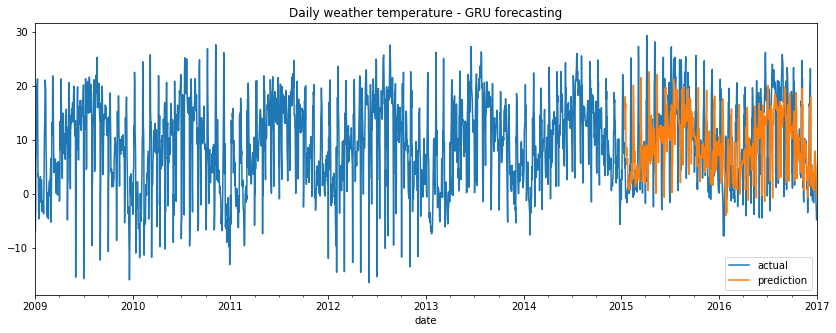

In [16]:
res_df = df.copy()
res_df['GRU_pred'] = pd.Series()

res_df['GRU_pred'][2205:] = results['GRU_pred']

res_df.plot()
plt.title('Daily weather temperature - GRU forecasting')
plt.legend(['actual', 'prediction'])
plt.show()

 ### LSTM

In [17]:
# LSTM model definition

np.random.seed(42)

lstm_model = Sequential()
lstm_model.add(LSTM(LATENT_DIM, input_shape=(6, 1)))
lstm_model.add(Dense(HORIZON))

lstm_model.compile(optimizer="RMSprop", loss="mse")
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [18]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history_lstm = lstm_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

lstm_pred = lstm_model.predict(X_test)

Epoch 1/50
46/46 [==============================] - 3s 16ms/step - loss: 0.0411 - val_loss: 0.0173
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0237 - val_loss: 0.0165
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0231 - val_loss: 0.0161
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.0157
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0222 - val_loss: 0.0155
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0217 - val_loss: 0.0150
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0213 - val_loss: 0.0148
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0210 - val_loss: 0.0145
Epoch 9/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.0141
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0137
Epoch 11/50
46/46 

In [19]:
results['LSTM_pred'] = scaler.inverse_transform(lstm_pred)

print(results.shape)
results.head()

(718, 3)


,y1,GRU_pred,LSTM_pred
date,,,
2015-01-01,22.116458,11.978891,12.397757
2015-01-02,18.175000,17.988037,19.003668
2015-01-03,20.717986,15.721015,16.140057
2015-01-04,8.910139,16.759583,17.040884
2015-01-05,9.433264,8.853665,8.277546


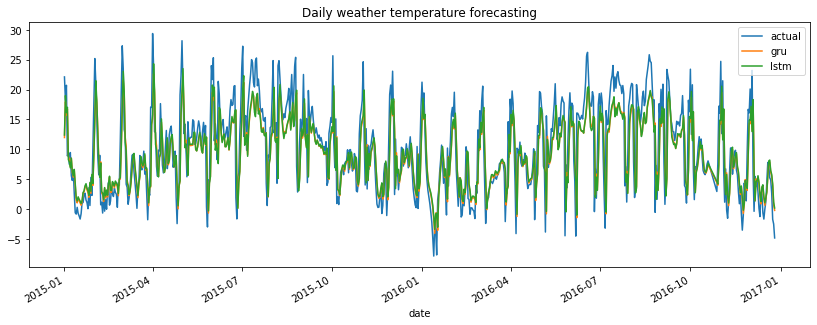

In [20]:
results[['y1','GRU_pred','LSTM_pred']].plot()
plt.title('Daily weather temperature forecasting')
plt.legend(['actual','gru','lstm'])
plt.show()

In [21]:
def model_evaluation (name_model, y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    res = pd.Series({'Model': name_model, 'mae' : mae, 'mse': mse, 'mape' : mape})
    
    return res

In [22]:
nets = ['GRU', 'LSTM']

res = []
for name in nets:
    result = model_evaluation(name+' one step pred', results['y1'], results[name+'_pred'])
    res.append(result)
    
resdf = pd.DataFrame(res)
resdf.sort_values(by=['mse'], inplace=True)
resdf   

,Model,mae,mse,mape
1,LSTM one step pred,3.745374,24.504416,1.922834
0,GRU one step pred,3.766740,24.785546,1.794499


# Multi-Step Forecast

### Predicting three steps ahead

window_in = 6      the number of lag variables

HORIZON = 3        next three days temperature

In [23]:
win_in = 6  
HORIZON = 3

train_shift = slideWindow(train, win_in, HORIZON)
valid_shift = slideWindow(valid, win_in, HORIZON)
test_shift = slideWindow(test, win_in, HORIZON)

train_shift.head()

,x1,x2,x3,x4,x5,x6,y1,y2,y3
date,,,,,,,,,
2009-01-01,0.218753,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971
2009-01-02,0.296990,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903
2009-01-03,0.496457,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903,0.446006
2009-01-04,0.538367,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903,0.446006,0.456699
2009-01-05,0.660961,0.717914,0.829488,0.800982,0.855971,0.643903,0.446006,0.456699,0.335139


In [24]:
print(train.shape, valid.shape, test.shape)

(1461, 1) (730, 1) (732, 1)


In [25]:
y_train = train_shift[['y1','y2','y3']].to_numpy()
print(y_train.shape)

X_train = train_shift.iloc[:,:-3].to_numpy()   # all columns except the last three   
X_train = X_train.reshape(X_train.shape[0], win_in, 1)
print(X_train.shape)

y_valid = valid_shift[['y1','y2','y3']].to_numpy()
print(y_valid.shape)
 
X_valid = valid_shift.iloc[:,:-3].to_numpy()   # 
X_valid = X_valid.reshape(X_valid.shape[0], win_in, 1)

print(X_valid.shape)

y_test = test_shift[['y1','y2','y3']].to_numpy()
print(y_test.shape)
 
X_test = test_shift.iloc[:,:-3].to_numpy()    
X_test = X_test.reshape(X_test.shape[0], win_in, 1)

print(X_test.shape)

(1453, 3)
(1453, 6, 1)
(722, 3)
(722, 6, 1)
(714, 3)
(714, 6, 1)


## GRU model to predict three days ahead temperature day

In [26]:
LATENT_DIM = 5
PATIENCE = 5
BATCH_SIZE = 32
EPOCHS = 150
HORIZON = 3

In [27]:
np.random.seed(42)

gru_model = Sequential()
gru_model.add(GRU(LATENT_DIM, input_shape=(win_in, 1)))
gru_model.add(Dense(HORIZON))

gru_model.compile(optimizer="RMSprop", loss="mse")
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 5)                 120       
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


In [28]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history = gru_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

gru_ts_pred = gru_model.predict(X_test)

Epoch 1/150
46/46 [==============================] - 3s 18ms/step - loss: 0.2713 - val_loss: 0.1730
Epoch 2/150
46/46 [==============================] - 0s 6ms/step - loss: 0.1060 - val_loss: 0.0621
Epoch 3/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0445 - val_loss: 0.0269
Epoch 4/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0307 - val_loss: 0.0228
Epoch 5/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0286 - val_loss: 0.0218
Epoch 6/150
46/46 [==============================] - 0s 6ms/step - loss: 0.0274 - val_loss: 0.0204
Epoch 7/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0265 - val_loss: 0.0205
Epoch 8/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0259 - val_loss: 0.0191
Epoch 9/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0253 - val_loss: 0.0194
Epoch 10/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0181
Epoch 11

In [29]:
results = pd.DataFrame()
results[['y1','y2','y3']] = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
results[['GRU_y1','GRU_y2','GRU_y3']] = scaler.inverse_transform(gru_ts_pred.reshape(-1, 1)).reshape(gru_ts_pred.shape)

print(results.shape)
results.head()

(714, 6)


,y1,y2,y3,GRU_y1,GRU_y2,GRU_y3
0,22.116458,18.175000,20.717986,12.523411,11.382564,9.462472
1,18.175000,20.717986,8.910139,18.605928,16.072947,12.210732
2,20.717986,8.910139,9.433264,15.862632,13.948435,10.882899
3,8.910139,9.433264,7.495208,17.386232,15.084674,12.076078
4,9.433264,7.495208,9.465625,9.328672,8.722893,8.747630


In [30]:
def plot_daily_predictions(results_df, horizon, descr):

    fig, ax = plt.subplots(horizon, 1, figsize=(8*horizon, 12))
    for i in range(horizon): 
        results_df.iloc[:,[i,i+horizon]].plot(title=descr,ax=ax[i])
    
    plt.show()

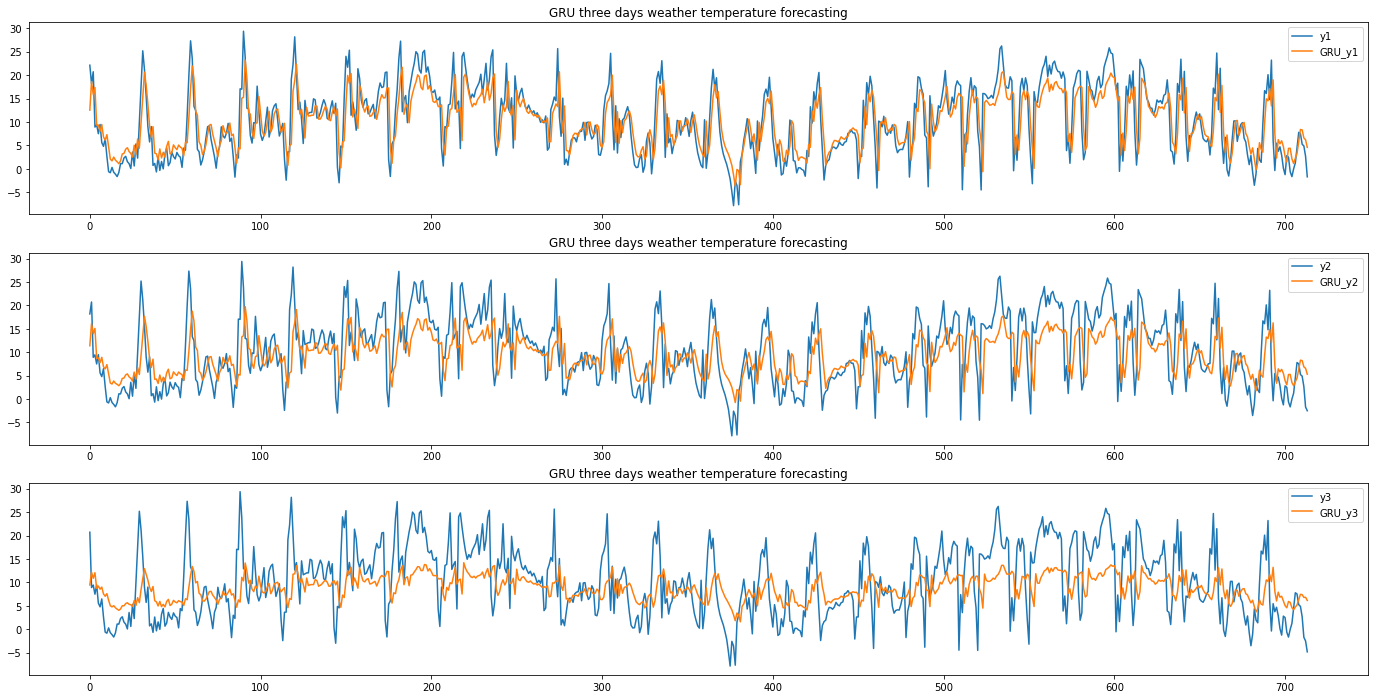

In [31]:
plot_daily_predictions(results, HORIZON, 'GRU three days weather temperature forecasting')

## LSTM three days ahead 

In [32]:
# LSTM model definition

np.random.seed(42)

lstm_model = Sequential()
lstm_model.add(LSTM(LATENT_DIM, input_shape=(win_in, 1)))
lstm_model.add(Dense(HORIZON))

lstm_model.compile(optimizer="RMSprop", loss="mse")
lstm_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
Total params: 158
Trainable params: 158
Non-trainable params: 0
_________________________________________________________________


In [33]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=PATIENCE)

history_lstm = lstm_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

lstm_pred = lstm_model.predict(X_test)

Epoch 1/150
46/46 [==============================] - 3s 19ms/step - loss: 0.1995 - val_loss: 0.1315
Epoch 2/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0786 - val_loss: 0.0397
Epoch 3/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0341 - val_loss: 0.0240
Epoch 4/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0230
Epoch 5/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0300 - val_loss: 0.0229
Epoch 6/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0295 - val_loss: 0.0223
Epoch 7/150
46/46 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0222
Epoch 8/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0291 - val_loss: 0.0217
Epoch 9/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0288 - val_loss: 0.0221
Epoch 10/150
46/46 [==============================] - 0s 7ms/step - loss: 0.0286 - val_loss: 0.0215
Epoch 11

In [34]:
results[['LSTM_y1','LSTM_y2','LSTM_y3']] = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).reshape(lstm_pred.shape)

print(results.shape)
results.head()

(714, 9)


,y1,y2,y3,GRU_y1,GRU_y2,GRU_y3,LSTM_y1,LSTM_y2,LSTM_y3
0,22.116458,18.175000,20.717986,12.523411,11.382564,9.462472,12.434151,11.293944,9.926795
1,18.175000,20.717986,8.910139,18.605928,16.072947,12.210732,18.952198,16.010712,12.864211
2,20.717986,8.910139,9.433264,15.862632,13.948435,10.882899,15.360840,13.700018,11.837463
3,8.910139,9.433264,7.495208,17.386232,15.084674,12.076078,16.903040,15.029534,12.819645
4,9.433264,7.495208,9.465625,9.328672,8.722893,8.747630,7.580388,8.525702,9.354923


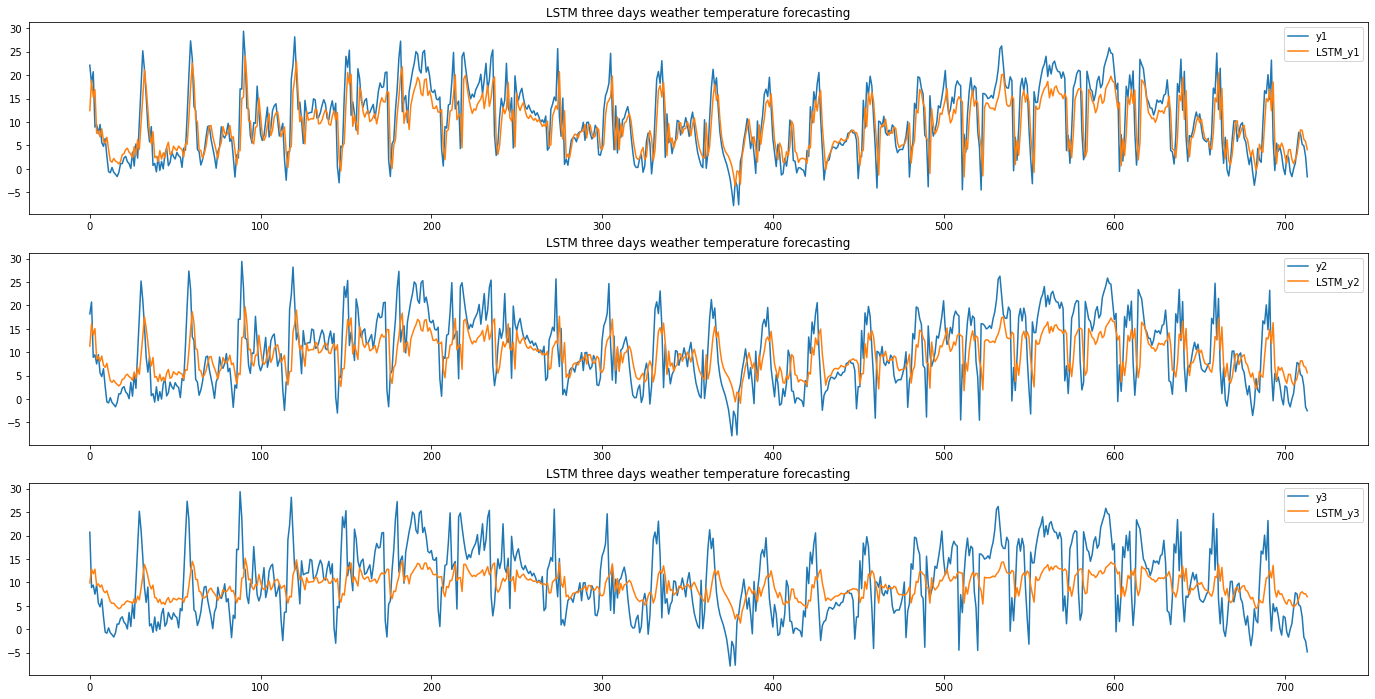

In [35]:
plot_daily_predictions(results.iloc[:,[0,1,2,6,7,8]], HORIZON, 'LSTM three days weather temperature forecasting')

In [36]:
nets = ['GRU', 'LSTM']

res = []
for name in nets:
    result = model_evaluation(name+' three steps ahed', results[['y1','y2','y3']], results[[name+'_y1',name+'_y2',name+'_y3']])
    res.append(result)
    
resdf = resdf.append(res)
resdf.sort_values(by=['mse'], inplace=True)
resdf   

,Model,mae,mse,mape
1,LSTM one step pred,3.745374,24.504416,1.922834
0,GRU one step pred,3.766740,24.785546,1.794499
1,LSTM three steps ahed,4.752206,36.791648,3.086964
0,GRU three steps ahed,4.716328,36.792124,2.997895
